# Análise Exploratória de Dados (EDA) - Sistema Único de Saúde (SUS)

Este notebook apresenta uma análise exploratória completa dos dados de compras de medicamentos do SUS, com foco em identificar padrões, anomalias e insights relevantes para políticas públicas de saúde.

In [17]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy import stats
from datetime import datetime
import math

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("📊 Bibliotecas carregadas com sucesso!")

📊 Bibliotecas carregadas com sucesso!


## 1. Carregamento e Visão Geral dos Dados

In [ ]:
# Carregamento dos dados
df = pd.read_csv('../data/sus/sus_data_geo.csv')

# Converter colunas de data para datetime
print("🔄 CONVERSÃO DE COLUNAS DE DATA")
print("=" * 35)

# Colunas de data identificadas
date_columns = ['compra', 'insercao']

# Converter para datetime
for col in date_columns:
    if col in df.columns:
        print(f"\nConvertendo coluna '{col}'...")
        df[col] = pd.to_datetime(df[col], errors='coerce')

print("\n✅ Conversão de datas concluída!")

# Informações básicas do dataset
print("📋 INFORMAÇÕES GERAIS DO DATASET")
print("=" * 50)
print(f"Total de registros: {len(df):,}")
print(f"Número de colunas: {df.shape[1]}")
print(f"Período dos dados: {df['compra'].min()} a {df['compra'].max()}")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Valores nulos: {df.isnull().sum().sum():,}")

# Tipos de dados
print(f"\n📊 TIPOS DE DADOS:")
print(df.dtypes.value_counts())

🔄 CONVERSÃO DE COLUNAS DE DATA

Convertendo coluna 'compra'...

Convertendo coluna 'insercao'...

✅ Conversão de datas concluída!
📋 INFORMAÇÕES GERAIS DO DATASET
Total de registros: 273,305
Número de colunas: 23
Período dos dados: 2020-01-01 00:00:00 a 2024-10-31 00:00:00
Memória utilizada: 323.7 MB
Valores nulos: 116,955

📊 TIPOS DE DADOS:
object            17
float64            3
datetime64[ns]     2
int64              1
Name: count, dtype: int64


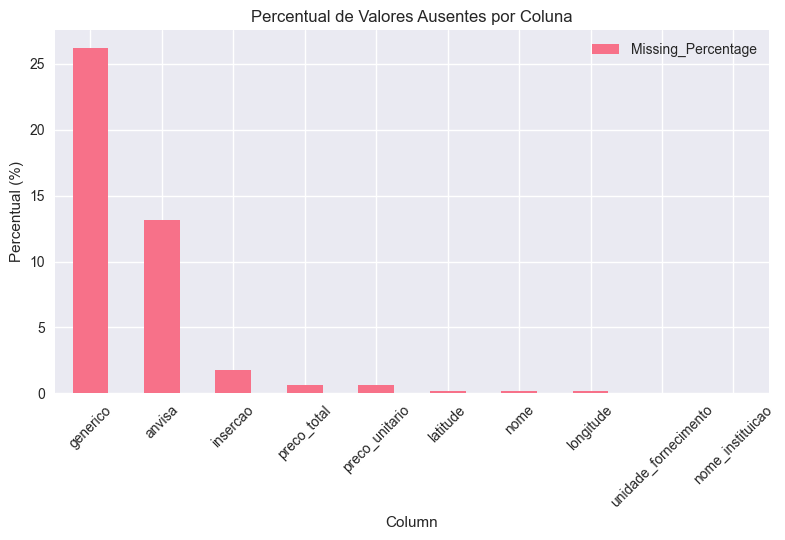

🔍 ANÁLISE DE VALORES AUSENTES:
                                    Column  Missing_Count  Missing_Percentage
generico                          generico          71697               26.23
anvisa                              anvisa          35908               13.14
insercao                          insercao           4807                1.76
preco_total                    preco_total           1674                0.61
preco_unitario              preco_unitario           1674                0.61
latitude                          latitude            369                0.14
nome                                  nome            369                0.14
longitude                        longitude            369                0.14
unidade_fornecimento  unidade_fornecimento             73                0.03
nome_instituicao          nome_instituicao             15                0.01


In [20]:
# Análise de valores ausentes
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

# Visualização de dados ausentes

# Gráfico de valores ausentes
ax = missing_data[missing_data['Missing_Percentage'] > 0].plot(
    x='Column', y='Missing_Percentage', kind='bar'
)
ax.set_title('Percentual de Valores Ausentes por Coluna')
ax.set_ylabel('Percentual (%)')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("🔍 ANÁLISE DE VALORES AUSENTES:")
print(missing_data[missing_data['Missing_Percentage'] > 0])

## 2. Limpeza e Preparação dos Dados

In [21]:
# Limpeza dos dados - removendo outliers extremos
print("🧹 LIMPEZA DOS DADOS")
print("=" * 30)

# Dados originais
original_shape = df.shape[0]
print(f"Registros originais: {original_shape:,}")

# Remover outliers de quantidade (acima de 10 milhões - provavelmente erros de digitação)
df = df[df['qtd_itens_comprados'] < 10_000_000]
print(f"Após remoção de qtd extrema: {df.shape[0]:,} ({df.shape[0]/original_shape*100:.1f}%)")

# Remover outliers de preço (acima de R$ 30.000 - provavelmente erros)
df = df[df['preco_unitario'] < 30_000]
print(f"Após remoção de preços extremos: {df.shape[0]:,} ({df.shape[0]/original_shape*100:.1f}%)")

# Criar variáveis derivadas
df['valor_total'] = df['preco_unitario'] * df['qtd_itens_comprados']
df['compra'] = pd.to_datetime(df['compra'])
df['ano'] = df['compra'].dt.year
df['mes'] = df['compra'].dt.month
df['trimestre'] = df['compra'].dt.quarter

print(f"✅ Limpeza concluída. Registros finais: {df.shape[0]:,}")

🧹 LIMPEZA DOS DADOS
Registros originais: 273,305
Após remoção de qtd extrema: 272,734 (99.8%)
Após remoção de preços extremos: 271,028 (99.2%)
✅ Limpeza concluída. Registros finais: 271,028


## 3. Estatísticas Descritivas Detalhadas

In [22]:
# Estatísticas descritivas das principais variáveis
print("📈 ESTATÍSTICAS DESCRITIVAS COMPLETAS")
print("=" * 50)

# Função para formatação de estatísticas
def format_stats(series, is_currency=False, is_integer=False):
    prefix = "R$ " if is_currency else ""
    formatter = "{:,.0f}" if is_integer else "{:,.2f}"
    
    stats_dict = {
        'count': f"{len(series):,}",
        'mean': prefix + formatter.format(series.mean()),
        'median': prefix + formatter.format(series.median()),
        'std': prefix + formatter.format(series.std()),
        'min': prefix + formatter.format(series.min()),
        'max': prefix + formatter.format(series.max()),
        'q25': prefix + formatter.format(series.quantile(0.25)),
        'q75': prefix + formatter.format(series.quantile(0.75)),
        'q95': prefix + formatter.format(series.quantile(0.95)),
        'q99': prefix + formatter.format(series.quantile(0.99))
    }
    return stats_dict

# Estatísticas das variáveis principais
variables = {
    'Preço Unitário': ('preco_unitario', True, False),
    'Quantidade': ('qtd_itens_comprados', False, True),
    'Valor Total': ('valor_total', True, False)
}

for var_name, (col_name, is_currency, is_integer) in variables.items():
    print(f"\n{var_name.upper()}:")
    stats = format_stats(df[col_name], is_currency, is_integer)
    for stat, value in stats.items():
        print(f"  {stat.capitalize()}: {value}")

📈 ESTATÍSTICAS DESCRITIVAS COMPLETAS

PREÇO UNITÁRIO:
  Count: 271,028
  Mean: R$ 22.52
  Median: R$ 1.80
  Std: R$ 281.42
  Min: R$ 0.00
  Max: R$ 29,713.80
  Q25: R$ 0.36
  Q75: R$ 6.90
  Q95: R$ 64.42
  Q99: R$ 300.00

QUANTIDADE:
  Count: 271,028
  Mean: 65,781
  Median: 1,550
  Std: 402,919
  Min: 1
  Max: 9,999,332
  Q25: 250
  Q75: 11,250
  Q95: 200,000
  Q99: 1,386,000

VALOR TOTAL:
  Count: 271,028
  Mean: R$ 90,387.08
  Median: R$ 2,640.00
  Std: R$ 5,772,533.71
  Min: R$ 0.00
  Max: R$ 2,160,239,780.00
  Q25: R$ 647.40
  Q75: R$ 12,000.00
  Q95: R$ 132,923.38
  Q99: R$ 874,823.13


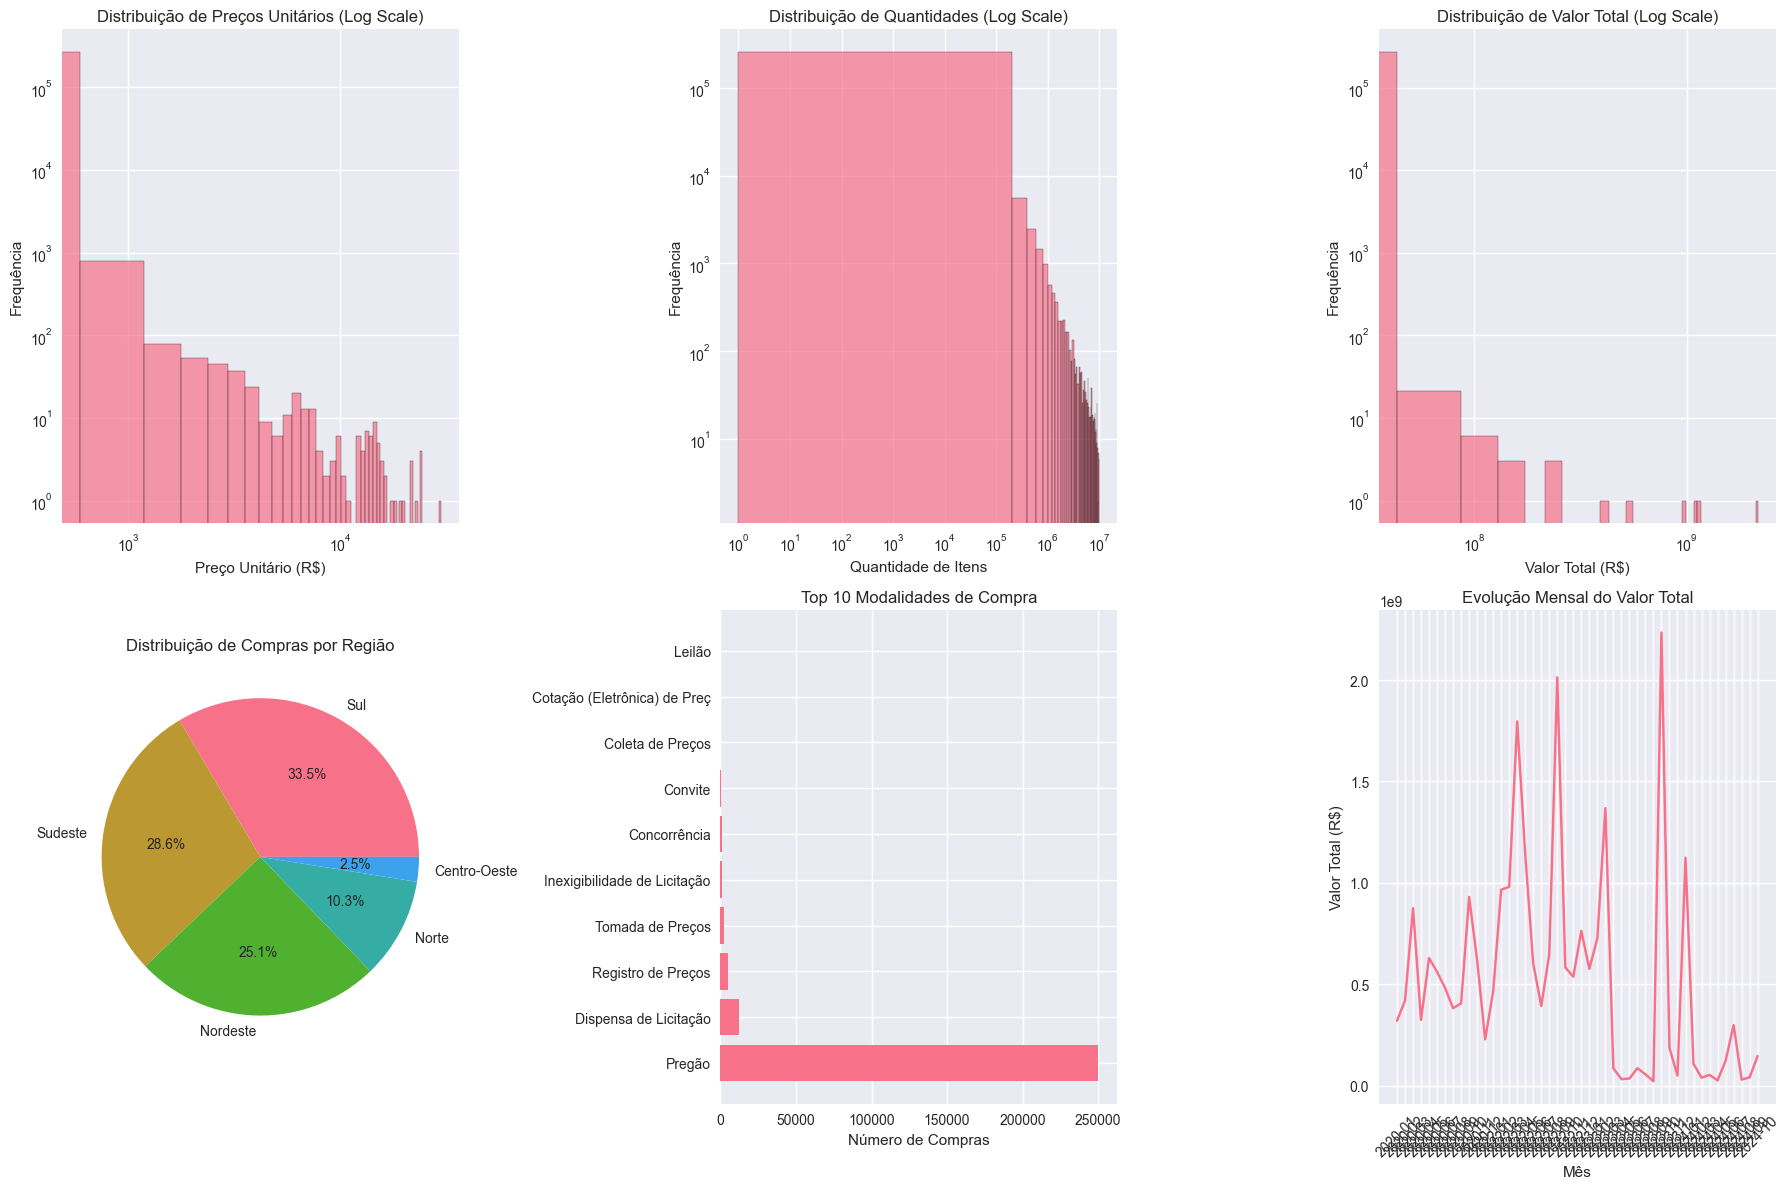

In [23]:
# Visualização das distribuições principais
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribuição de preços (log scale)
axes[0,0].hist(df['preco_unitario'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')
axes[0,0].set_title('Distribuição de Preços Unitários (Log Scale)')
axes[0,0].set_xlabel('Preço Unitário (R$)')
axes[0,0].set_ylabel('Frequência')

# 2. Distribuição de quantidades (log scale)
axes[0,1].hist(df['qtd_itens_comprados'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_yscale('log')
axes[0,1].set_xscale('log')
axes[0,1].set_title('Distribuição de Quantidades (Log Scale)')
axes[0,1].set_xlabel('Quantidade de Itens')
axes[0,1].set_ylabel('Frequência')

# 3. Distribuição de valor total (log scale)
axes[0,2].hist(df['valor_total'], bins=50, alpha=0.7, edgecolor='black')
axes[0,2].set_yscale('log')
axes[0,2].set_xscale('log')
axes[0,2].set_title('Distribuição de Valor Total (Log Scale)')
axes[0,2].set_xlabel('Valor Total (R$)')
axes[0,2].set_ylabel('Frequência')

# 4. Compras por região
region_counts = df['regiao'].value_counts()
axes[1,0].pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('Distribuição de Compras por Região')

# 5. Top 10 modalidades de compra
top_modalidades = df['modalidade_da_compra'].value_counts().head(10)
axes[1,1].barh(range(len(top_modalidades)), top_modalidades.values)
axes[1,1].set_yticks(range(len(top_modalidades)))
axes[1,1].set_yticklabels(top_modalidades.index)
axes[1,1].set_title('Top 10 Modalidades de Compra')
axes[1,1].set_xlabel('Número de Compras')

# 6. Evolução temporal
monthly_purchases = df.groupby([df['compra'].dt.to_period('M')])['valor_total'].sum()
axes[1,2].plot(monthly_purchases.index.astype(str), monthly_purchases.values)
axes[1,2].set_title('Evolução Mensal do Valor Total')
axes[1,2].set_xlabel('Mês')
axes[1,2].set_ylabel('Valor Total (R$)')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Análise Regional Detalhada

🗺️ ANÁLISE REGIONAL
Estatísticas por Região:
             preco_unitario                     qtd_itens_comprados           \
                      count  mean median    std                 sum     mean   
regiao                                                                         
Centro-Oeste           6817 78.33   2.48 753.86           364641302 53490.00   
Nordeste              68013 19.75   1.98 235.86          3787044204 55681.18   
Norte                 27890 21.48   2.62 134.07           492146109 17645.97   
Sudeste               77481 28.54   1.54 373.79          6036253942 77906.25   
Sul                   90827 15.60   1.65 164.29          7148542574 78705.04   

                       valor_total                    
              median           sum      mean  median  
regiao                                                
Centro-Oeste 2000.00  881928926.21 129372.00 4482.00  
Nordeste     1300.00 8425348781.47 123878.51 2268.00  
Norte        1625.00  758565260.61  271

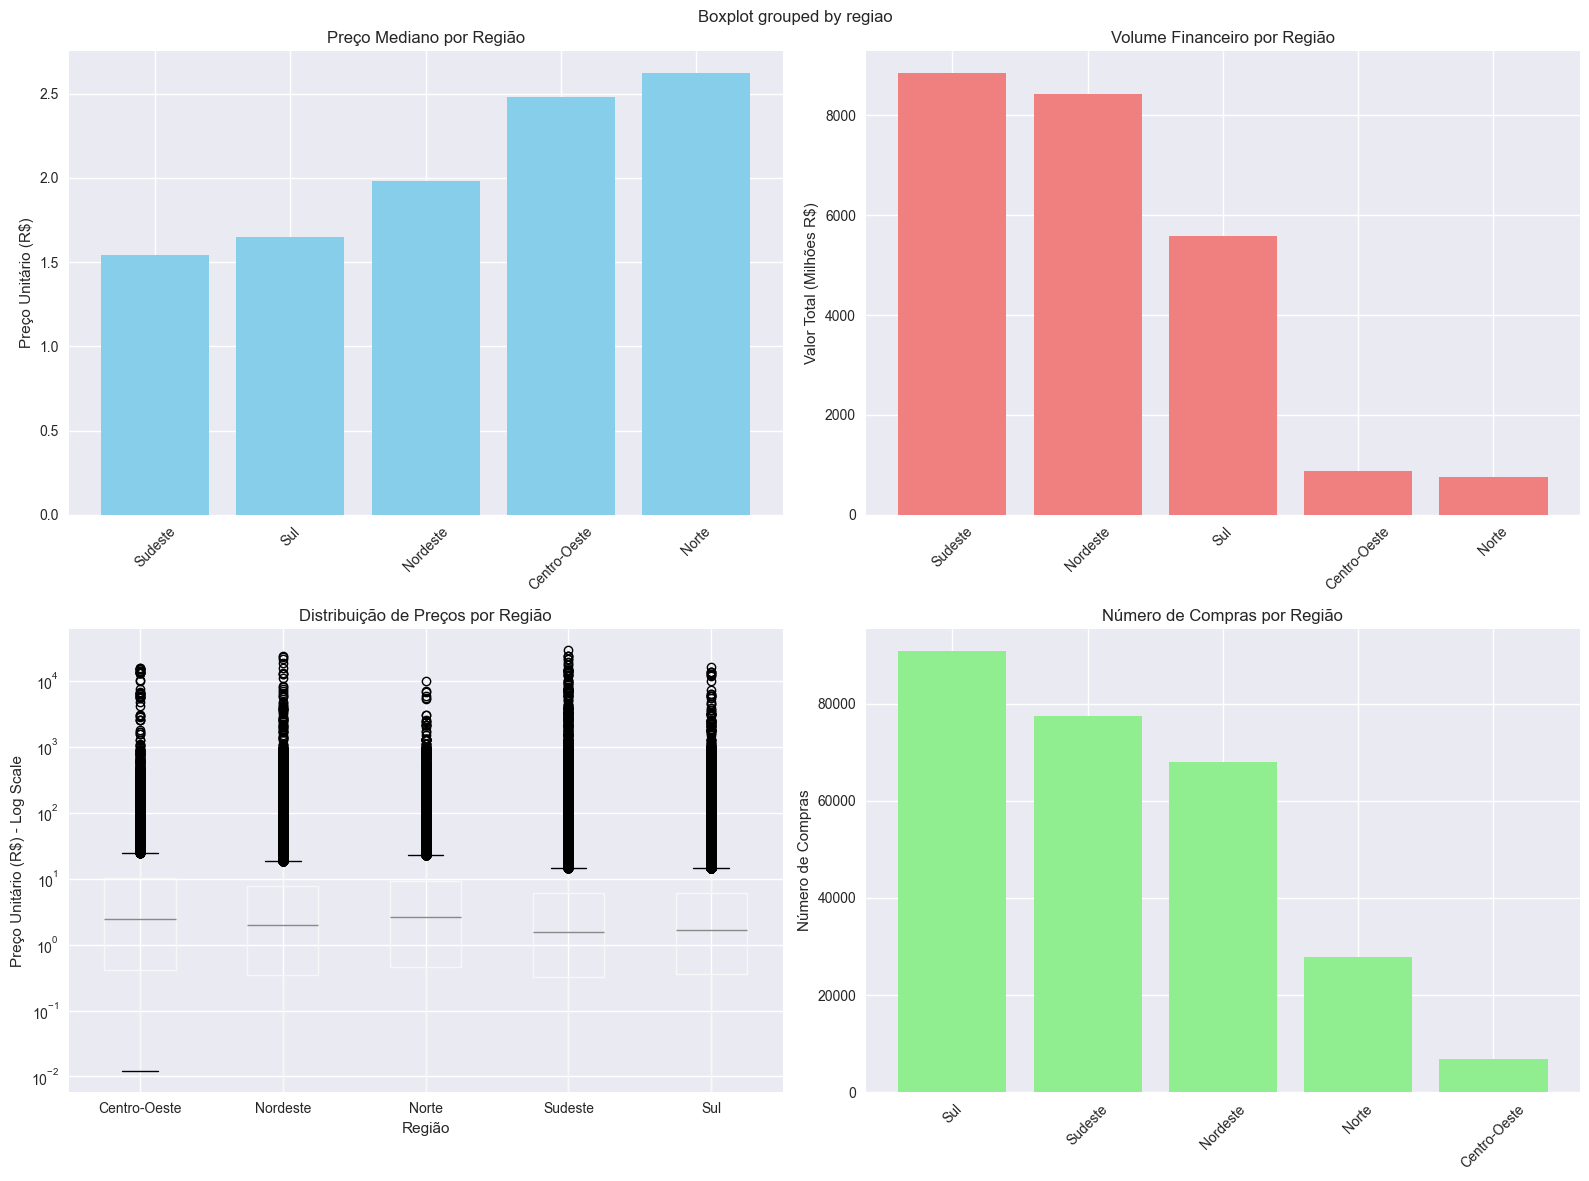

In [24]:
# Análise por região
print("🗺️ ANÁLISE REGIONAL")
print("=" * 30)

# Estatísticas por região
regional_stats = df.groupby('regiao').agg({
    'preco_unitario': ['count', 'mean', 'median', 'std'],
    'qtd_itens_comprados': ['sum', 'mean', 'median'],
    'valor_total': ['sum', 'mean', 'median']
}).round(2)

print("Estatísticas por Região:")
print(regional_stats)

# Análise de preços por estado
state_analysis = df.groupby(['regiao', 'uf']).agg({
    'preco_unitario': ['count', 'median', 'mean'],
    'valor_total': 'sum'
}).round(2)

# Visualizações regionais
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Preço mediano por região
regional_prices = df.groupby('regiao')['preco_unitario'].median().sort_values()
axes[0,0].bar(regional_prices.index, regional_prices.values, color='skyblue')
axes[0,0].set_title('Preço Mediano por Região')
axes[0,0].set_ylabel('Preço Unitário (R$)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Volume financeiro por região
regional_volume = df.groupby('regiao')['valor_total'].sum().sort_values(ascending=False)
axes[0,1].bar(regional_volume.index, regional_volume.values/1e6, color='lightcoral')
axes[0,1].set_title('Volume Financeiro por Região')
axes[0,1].set_ylabel('Valor Total (Milhões R$)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Boxplot de preços por região
df.boxplot(column='preco_unitario', by='regiao', ax=axes[1,0])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Distribuição de Preços por Região')
axes[1,0].set_xlabel('Região')
axes[1,0].set_ylabel('Preço Unitário (R$) - Log Scale')

# 4. Número de compras por região
purchase_counts = df.groupby('regiao').size().sort_values(ascending=False)
axes[1,1].bar(purchase_counts.index, purchase_counts.values, color='lightgreen')
axes[1,1].set_title('Número de Compras por Região')
axes[1,1].set_ylabel('Número de Compras')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Análise de Modalidades de Compra

🏪 ANÁLISE DE MODALIDADES DE COMPRA
Top 10 Modalidades por Número de Transações:
                             preco_unitario                       \
                                      count   mean median    std   
modalidade_da_compra                                               
Pregão                               250088  20.20   1.71 243.37   
Dispensa de Licitação                 12203  64.98   3.40 660.89   
Registro de Preços                     4820  20.39   1.42 344.33   
Tomada de Preços                       2150   9.72   1.68  50.12   
Inexigibilidade de Licitação            981 129.33  21.46 849.30   
Concorrência                            725  16.29   1.69  45.14   
Convite                                  58  52.84   3.12 187.42   
Coleta de Preços                          1   2.18   2.18    NaN   
Cotação (Eletrônica) de Preç              1   2.18   2.18    NaN   
Leilão                                    1   0.70   0.70    NaN   

                             qtd_it

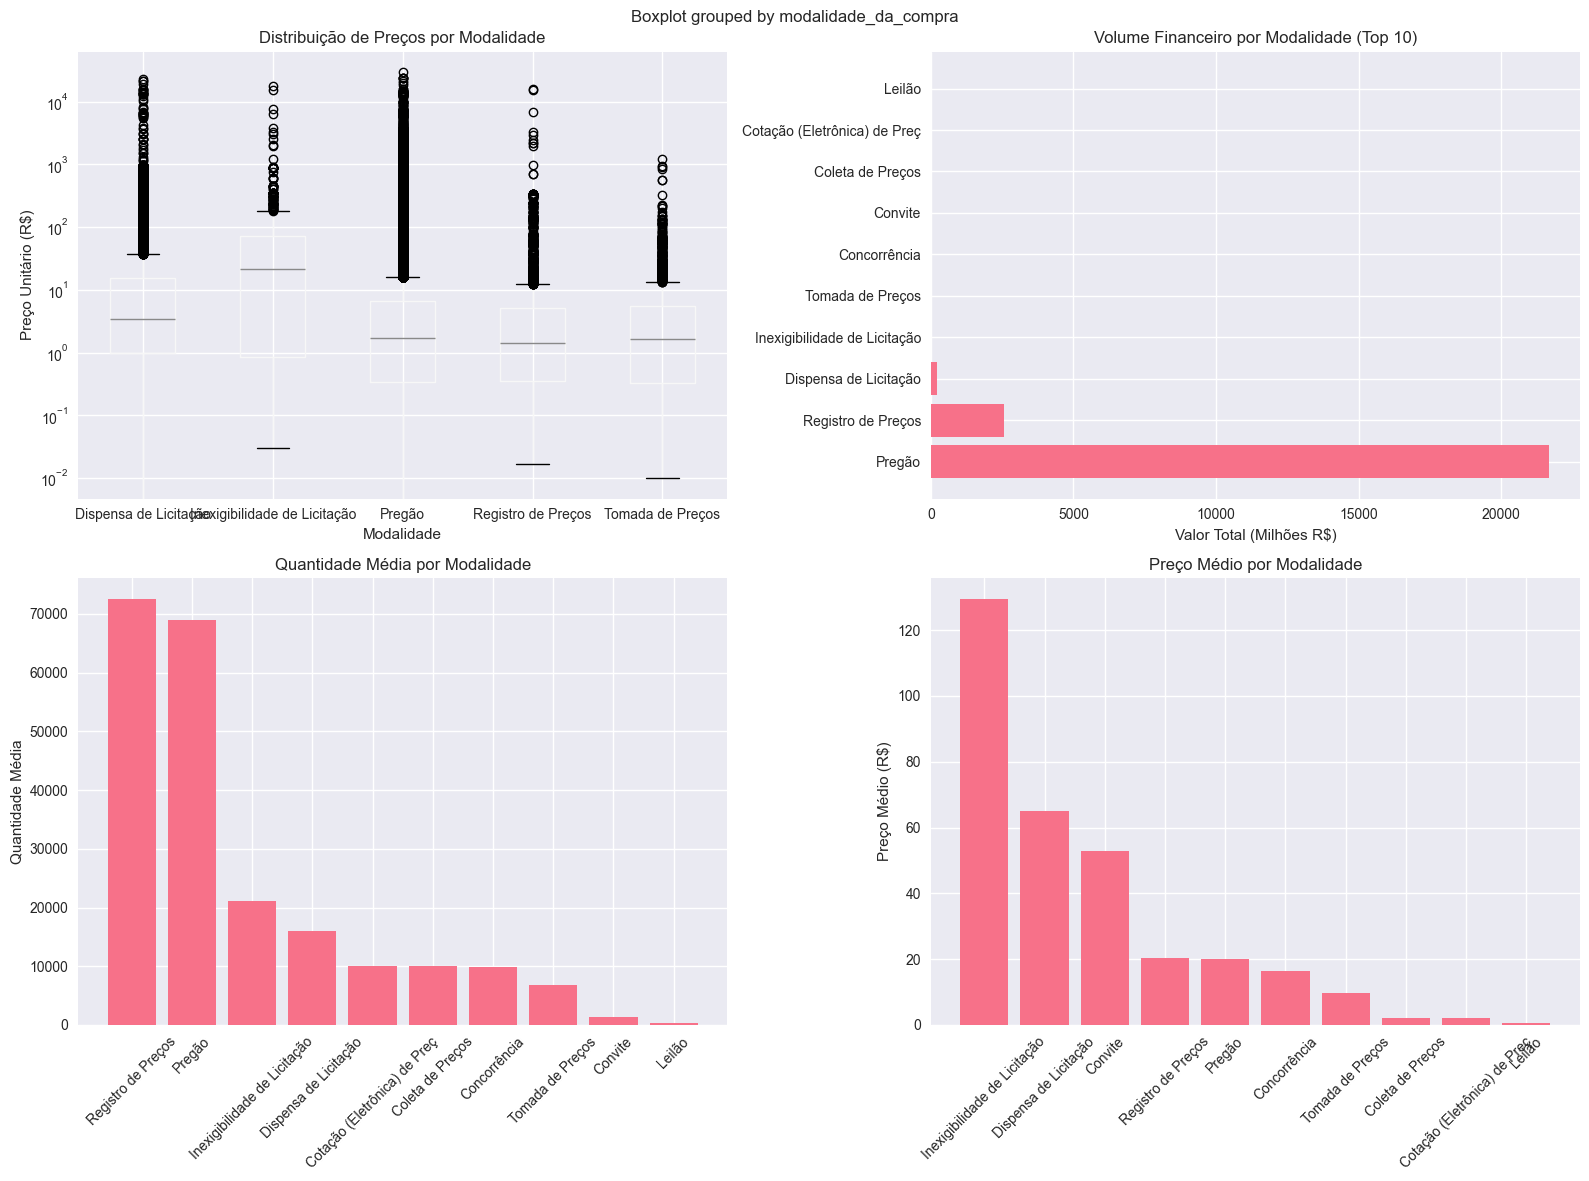

In [25]:
# Análise detalhada das modalidades de compra
print("🏪 ANÁLISE DE MODALIDADES DE COMPRA")
print("=" * 40)

# Top modalidades
modalidade_stats = df.groupby('modalidade_da_compra').agg({
    'preco_unitario': ['count', 'mean', 'median', 'std'],
    'qtd_itens_comprados': ['sum', 'mean'],
    'valor_total': ['sum', 'mean']
}).round(2)

# Ordenar por número de transações
modalidade_stats = modalidade_stats.sort_values(('preco_unitario', 'count'), ascending=False)

print("Top 10 Modalidades por Número de Transações:")
print(modalidade_stats.head(10))

# Análise de dispersão de preços por modalidade
top_modalidades = df['modalidade_da_compra'].value_counts().head(5).index
df_top_modalidades = df[df['modalidade_da_compra'].isin(top_modalidades)]

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparação de preços por modalidade (boxplot)
df_top_modalidades.boxplot(
    column='preco_unitario', 
    by='modalidade_da_compra', 
    ax=axes[0,0]
)
axes[0,0].set_yscale('log')
axes[0,0].set_title('Distribuição de Preços por Modalidade')
axes[0,0].set_xlabel('Modalidade')
axes[0,0].set_ylabel('Preço Unitário (R$)')

# 2. Volume por modalidade
modalidade_volume = df.groupby('modalidade_da_compra')['valor_total'].sum().sort_values(ascending=False).head(10)
axes[0,1].barh(range(len(modalidade_volume)), modalidade_volume.values/1e6)
axes[0,1].set_yticks(range(len(modalidade_volume)))
axes[0,1].set_yticklabels(modalidade_volume.index)
axes[0,1].set_title('Volume Financeiro por Modalidade (Top 10)')
axes[0,1].set_xlabel('Valor Total (Milhões R$)')

# 3. Quantidade média por modalidade
modalidade_qty = df.groupby('modalidade_da_compra')['qtd_itens_comprados'].mean().sort_values(ascending=False).head(10)
axes[1,0].bar(range(len(modalidade_qty)), modalidade_qty.values)
axes[1,0].set_xticks(range(len(modalidade_qty)))
axes[1,0].set_xticklabels(modalidade_qty.index, rotation=45)
axes[1,0].set_title('Quantidade Média por Modalidade')
axes[1,0].set_ylabel('Quantidade Média')

# 4. Preço médio por modalidade
modalidade_price = df.groupby('modalidade_da_compra')['preco_unitario'].mean().sort_values(ascending=False).head(10)
axes[1,1].bar(range(len(modalidade_price)), modalidade_price.values)
axes[1,1].set_xticks(range(len(modalidade_price)))
axes[1,1].set_xticklabels(modalidade_price.index, rotation=45)
axes[1,1].set_title('Preço Médio por Modalidade')
axes[1,1].set_ylabel('Preço Médio (R$)')

plt.tight_layout()
plt.show()

## 6. Análise de Fornecedores

🏭 ANÁLISE DE FORNECEDORES
Top 20 Fornecedores por Volume Financeiro:
                                                 valor_total  preco_unitario  \
fornecedor                                                                     
ELFA MEDICAMENT                                3351157771.04             177   
UNIQUE DISTRIBUIDORA DE MEDICAMENTOS LTDA      2176681910.47              63   
ATIVA COMERCIAL HOSPITALAR LTDA                 963196169.60              70   
AGIL MEDICAMENT                                 552264847.48             329   
CRISTALIA PRODU                                 442153818.18            3632   
JANSSEN-CILAG F                                 377771504.04              87   
SULMEDIC COMERC                                 376063771.66             309   
ONCO PROD DISTR                                 360877506.78             371   
LABORATORIO QUI                                 298662878.33              18   
NOVARTIS BIOCIE                                 279

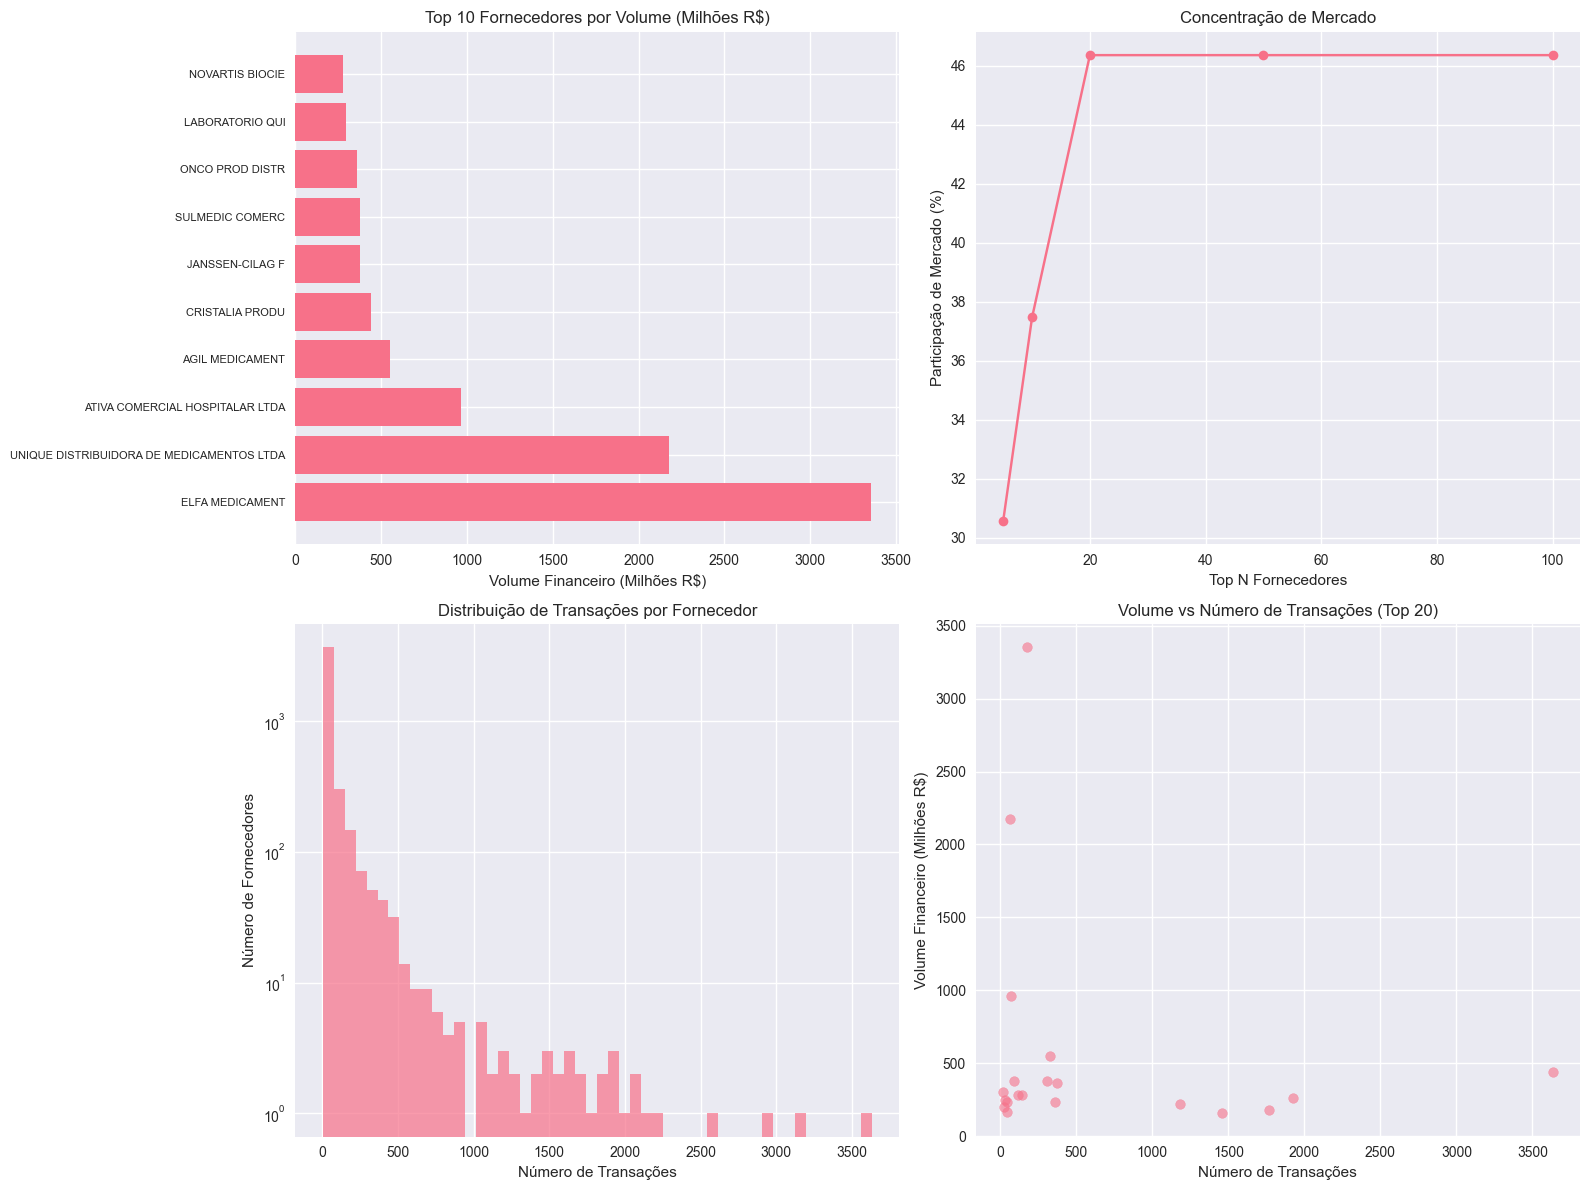

In [26]:
# Análise de concentração de fornecedores
print("🏭 ANÁLISE DE FORNECEDORES")
print("=" * 30)

# Top fornecedores por volume financeiro
top_suppliers = df.groupby('fornecedor').agg({
    'valor_total': 'sum',
    'preco_unitario': 'count',
    'qtd_itens_comprados': 'sum'
}).sort_values('valor_total', ascending=False).head(20)

total_market = df['valor_total'].sum()
top_suppliers['market_share'] = (top_suppliers['valor_total'] / total_market) * 100
top_suppliers['avg_price'] = df.groupby('fornecedor')['preco_unitario'].mean()

print("Top 20 Fornecedores por Volume Financeiro:")
print(top_suppliers)

# Análise de concentração
concentration_analysis = []
for n in [5, 10, 20, 50, 100]:
    top_n_share = top_suppliers.head(n)['market_share'].sum()
    concentration_analysis.append({
        'top_n': n,
        'market_share': top_n_share,
        'suppliers_count': len(df['fornecedor'].unique())
    })

concentration_df = pd.DataFrame(concentration_analysis)
print(f"\nAnálise de Concentração de Mercado:")
print(concentration_df)

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 fornecedores por volume
top_10_suppliers = top_suppliers.head(10)
axes[0,0].barh(range(len(top_10_suppliers)), top_10_suppliers['valor_total']/1e6)
axes[0,0].set_yticks(range(len(top_10_suppliers)))
axes[0,0].set_yticklabels(top_10_suppliers.index, fontsize=8)
axes[0,0].set_title('Top 10 Fornecedores por Volume (Milhões R$)')
axes[0,0].set_xlabel('Volume Financeiro (Milhões R$)')

# 2. Concentração de mercado
axes[0,1].plot(concentration_df['top_n'], concentration_df['market_share'], marker='o')
axes[0,1].set_title('Concentração de Mercado')
axes[0,1].set_xlabel('Top N Fornecedores')
axes[0,1].set_ylabel('Participação de Mercado (%)')
axes[0,1].grid(True)

# 3. Distribuição do número de transações por fornecedor
supplier_transactions = df['fornecedor'].value_counts()
axes[1,0].hist(supplier_transactions.values, bins=50, alpha=0.7)
axes[1,0].set_yscale('log')
axes[1,0].set_title('Distribuição de Transações por Fornecedor')
axes[1,0].set_xlabel('Número de Transações')
axes[1,0].set_ylabel('Número de Fornecedores')

# 4. Relação entre volume e número de transações
axes[1,1].scatter(
    top_suppliers['preco_unitario'], 
    top_suppliers['valor_total']/1e6,
    alpha=0.6
)
axes[1,1].set_title('Volume vs Número de Transações (Top 20)')
axes[1,1].set_xlabel('Número de Transações')
axes[1,1].set_ylabel('Volume Financeiro (Milhões R$)')

plt.tight_layout()
plt.show()

## 7. Análise Temporal

📅 ANÁLISE TEMPORAL
Evolução Trimestral:
                 valor_total        preco_unitario
                         sum  count           mean
ano  trimestre                                    
2020 1         1612641253.07  43522          13.77
     2         1514540411.33  43717          14.07
     3         1269049548.82  32342          13.54
     4         1777412846.03  21387          16.69
2022 1         2410040285.42  21833          15.45
     2         3539727093.92  21414          18.00
     3         3051976724.81  16122          18.07
     4         1883647067.19   8670          19.42
2023 1         2670775571.55  23048          63.70
     2          152158380.28   1698          43.92

Análise de Sazonalidade por Mês:
      valor_total                  preco_unitario
              sum      mean  count           mean
mes                                              
1   2483026075.95 102418.17  24244          24.15
2   2218543025.30  64983.69  34140          22.51
3   326199827

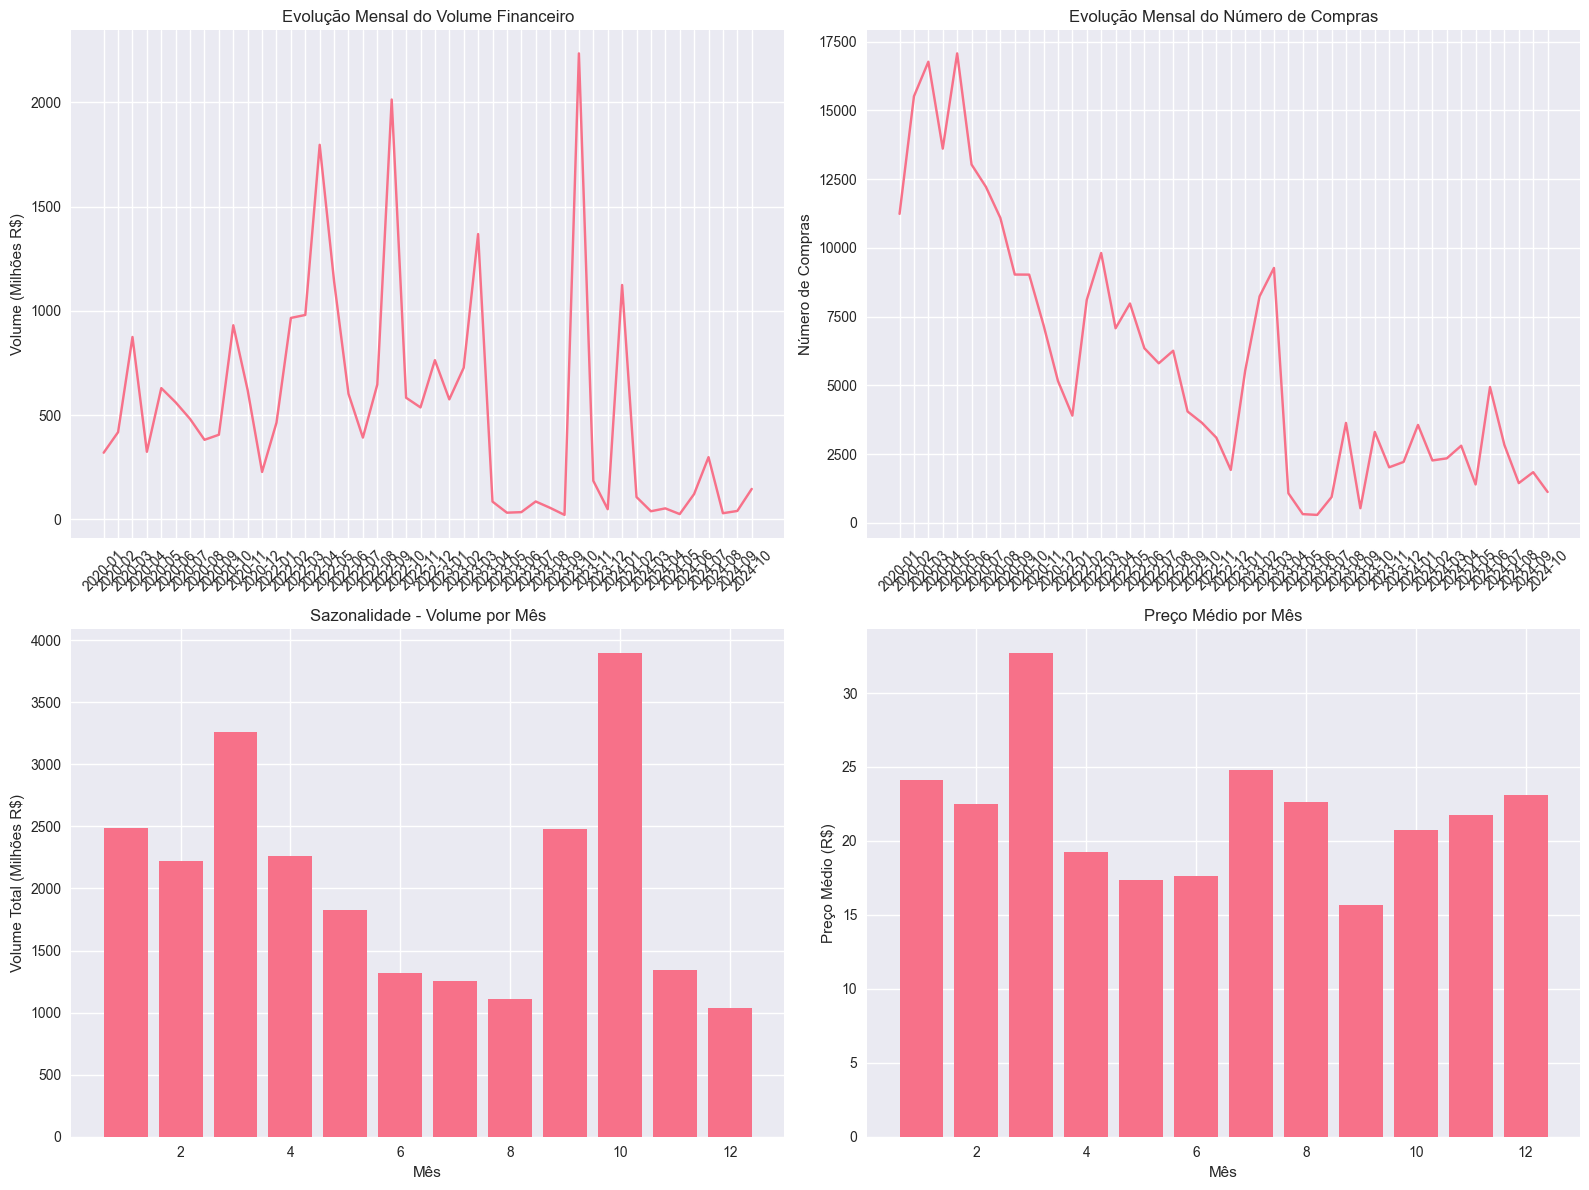

In [27]:
# Análise temporal detalhada
print("📅 ANÁLISE TEMPORAL")
print("=" * 25)

# Séries temporais
monthly_data = df.groupby(df['compra'].dt.to_period('M')).agg({
    'valor_total': ['sum', 'mean', 'count'],
    'preco_unitario': 'mean',
    'qtd_itens_comprados': 'sum'
})

quarterly_data = df.groupby(['ano', 'trimestre']).agg({
    'valor_total': ['sum', 'count'],
    'preco_unitario': 'mean'
})

print("Evolução Trimestral:")
print(quarterly_data.head(10))

# Análise de sazonalidade
seasonal_analysis = df.groupby('mes').agg({
    'valor_total': ['sum', 'mean', 'count'],
    'preco_unitario': 'mean'
}).round(2)

print(f"\nAnálise de Sazonalidade por Mês:")
print(seasonal_analysis)

# Visualizações temporais
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolução mensal do volume total
monthly_volume = monthly_data[('valor_total', 'sum')]
axes[0,0].plot(monthly_volume.index.astype(str), monthly_volume.values/1e6)
axes[0,0].set_title('Evolução Mensal do Volume Financeiro')
axes[0,0].set_ylabel('Volume (Milhões R$)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True)

# 2. Evolução mensal do número de compras
monthly_count = monthly_data[('valor_total', 'count')]
axes[0,1].plot(monthly_count.index.astype(str), monthly_count.values)
axes[0,1].set_title('Evolução Mensal do Número de Compras')
axes[0,1].set_ylabel('Número de Compras')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True)

# 3. Sazonalidade por mês
seasonal_volume = seasonal_analysis[('valor_total', 'sum')]
axes[1,0].bar(seasonal_volume.index, seasonal_volume.values/1e6)
axes[1,0].set_title('Sazonalidade - Volume por Mês')
axes[1,0].set_xlabel('Mês')
axes[1,0].set_ylabel('Volume Total (Milhões R$)')

# 4. Preço médio por mês
seasonal_price = seasonal_analysis[('preco_unitario', 'mean')]
axes[1,1].bar(seasonal_price.index, seasonal_price.values)
axes[1,1].set_title('Preço Médio por Mês')
axes[1,1].set_xlabel('Mês')
axes[1,1].set_ylabel('Preço Médio (R$)')

plt.tight_layout()
plt.show()

## 8. Análise de Correlações

🔗 ANÁLISE DE CORRELAÇÕES
Matriz de Correlação:
                     preco_unitario  qtd_itens_comprados  valor_total
preco_unitario                 1.00                -0.01         0.08
qtd_itens_comprados           -0.01                 1.00         0.04
valor_total                    0.08                 0.04         1.00


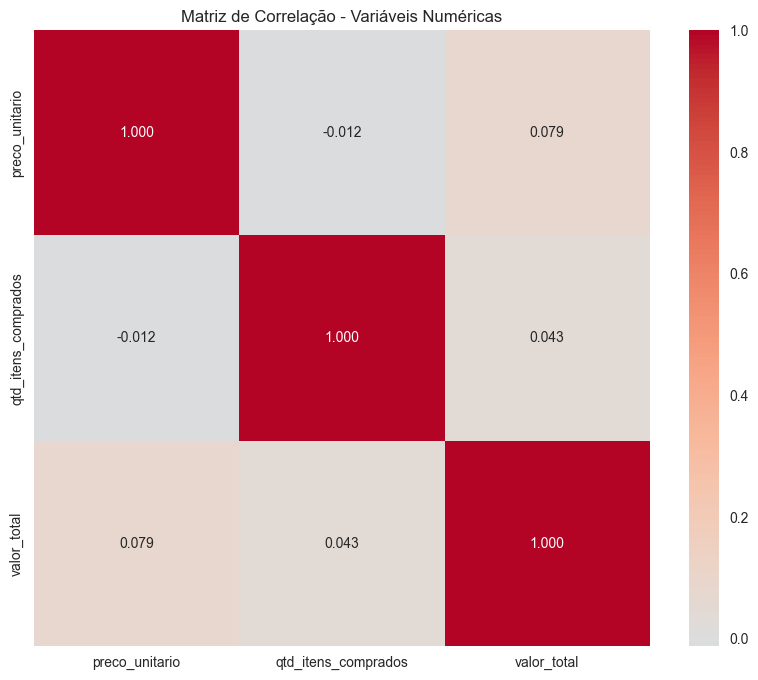


Preço médio por categoria:

REGIAO:
regiao
Sul            15.60
Nordeste       19.75
Norte          21.48
Sudeste        28.54
Centro-Oeste   78.33
Name: preco_unitario, dtype: float64

MODALIDADE:
modalidade_da_compra
Inexigibilidade de Licitação   129.33
Dispensa de Licitação           64.98
Convite                         52.84
Registro de Preços              20.39
Pregão                          20.20
Concorrência                    16.29
Tomada de Preços                 9.72
Coleta de Preços                 2.18
Cotação (Eletrônica) de Preç     2.18
Leilão                           0.70
Name: preco_unitario, dtype: float64


In [28]:
# Análise de correlações
print("🔗 ANÁLISE DE CORRELAÇÕES")
print("=" * 30)

# Seleção de variáveis numéricas para correlação
numeric_vars = ['preco_unitario', 'qtd_itens_comprados', 'valor_total']
correlation_matrix = df[numeric_vars].corr()

print("Matriz de Correlação:")
print(correlation_matrix)

# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    square=True,
    fmt='.3f'
)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()

# Análise de correlação entre preço e outras variáveis categóricas
categorical_price_analysis = {}

# Correlação preço vs região
regional_prices = df.groupby('regiao')['preco_unitario'].mean().sort_values()
categorical_price_analysis['regiao'] = regional_prices

# Correlação preço vs modalidade (top 10)
modalidade_prices = df.groupby('modalidade_da_compra')['preco_unitario'].mean().sort_values(ascending=False).head(10)
categorical_price_analysis['modalidade'] = modalidade_prices

print(f"\nPreço médio por categoria:")
for category, data in categorical_price_analysis.items():
    print(f"\n{category.upper()}:")
    print(data)

## 9. Análise de Anomalias e Outliers

🚨 DETECÇÃO DE ANOMALIAS E OUTLIERS
Outliers de Preço (IQR method):
  Limite inferior: R$ -9.45
  Limite superior: R$ 16.71
  Número de outliers: 36,828 (13.59%)

Outliers de Quantidade (IQR method):
  Limite inferior: -16250
  Limite superior: 27750
  Número de outliers: 45,587 (16.82%)

Top 10 Compras Mais Caras:
        uf municipio_instituicao  \
247016  RJ        RIO DE JANEIRO   
252167  SP               BARUERI   
222213  CE     JUAZEIRO DO NORTE   
211640  ES               VITORIA   
228492  ES               VITORIA   
267838  PB           JOAO PESSOA   
259551  BA              SALVADOR   
266040  SP               BARUERI   
227939  SP               UBATUBA   
232260  SP        RIBEIRAO PRETO   

                                         descricao_catmat  preco_unitario  \
247016  ALENTUZUMABE, CONCENTRAÇÃO:10 MG/ML, FORMA FAR...        29713.80   
252167  BUDESONIDA, CONCENTRAÇÃO:50 MCG/DOSE, FORMA FA...        23980.00   
222213  SUNITINIBE, COMPOSIÇÃO:MALATO, CONCENTRAÇÃO:50 M

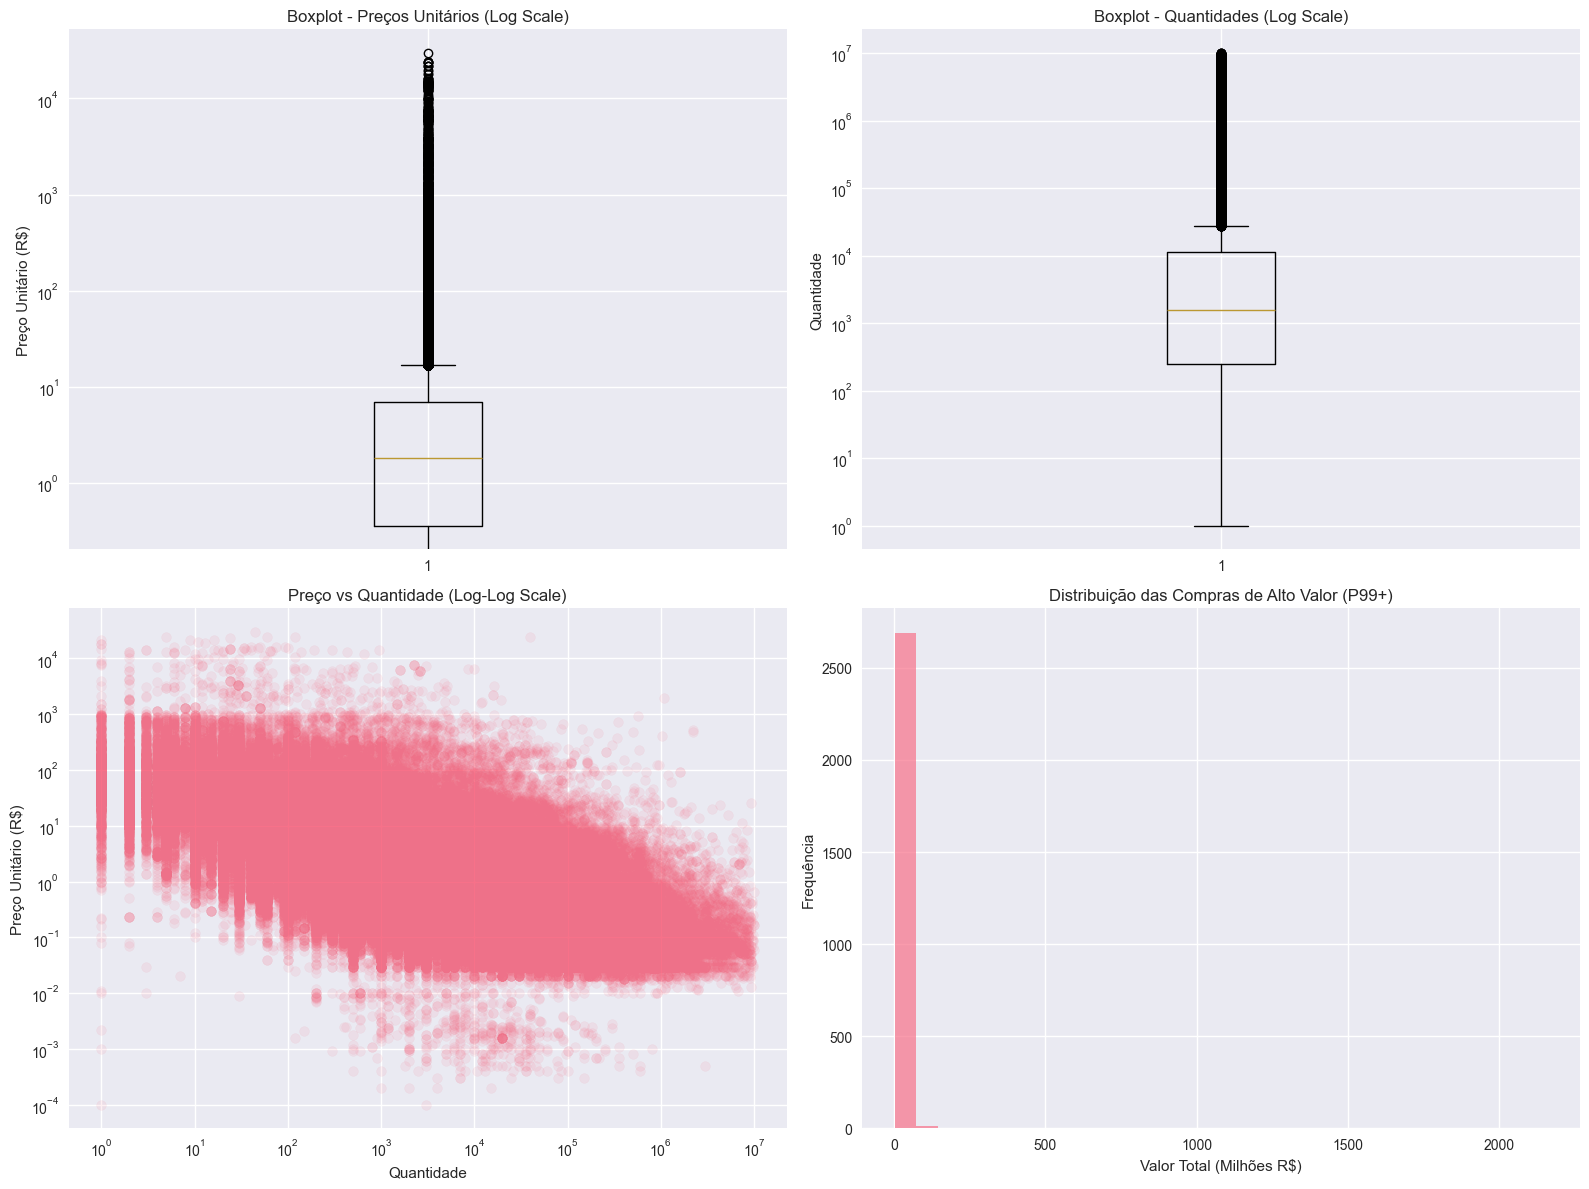

In [29]:
# Detecção de anomalias
print("🚨 DETECÇÃO DE ANOMALIAS E OUTLIERS")
print("=" * 40)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando o método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Análise de outliers para preços
price_outliers, price_lower, price_upper = detect_outliers_iqr(df, 'preco_unitario')
print(f"Outliers de Preço (IQR method):")
print(f"  Limite inferior: R$ {price_lower:.2f}")
print(f"  Limite superior: R$ {price_upper:.2f}")
print(f"  Número de outliers: {len(price_outliers):,} ({len(price_outliers)/len(df)*100:.2f}%)")

# Análise de outliers para quantidades
qty_outliers, qty_lower, qty_upper = detect_outliers_iqr(df, 'qtd_itens_comprados')
print(f"\nOutliers de Quantidade (IQR method):")
print(f"  Limite inferior: {qty_lower:.0f}")
print(f"  Limite superior: {qty_upper:.0f}")
print(f"  Número de outliers: {len(qty_outliers):,} ({len(qty_outliers)/len(df)*100:.2f}%)")

# Top 10 compras mais caras
top_expensive = df.nlargest(10, 'preco_unitario')[['uf', 'municipio_instituicao', 'descricao_catmat', 'preco_unitario', 'fornecedor']]
print(f"\nTop 10 Compras Mais Caras:")
print(top_expensive)

# Top 10 maiores quantidades
top_quantities = df.nlargest(10, 'qtd_itens_comprados')[['uf', 'municipio_instituicao', 'descricao_catmat', 'qtd_itens_comprados', 'preco_unitario']]
print(f"\nTop 10 Maiores Quantidades:")
print(top_quantities)

# Visualizações de outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Boxplot de preços com outliers
axes[0,0].boxplot(df['preco_unitario'])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Boxplot - Preços Unitários (Log Scale)')
axes[0,0].set_ylabel('Preço Unitário (R$)')

# 2. Boxplot de quantidades com outliers
axes[0,1].boxplot(df['qtd_itens_comprados'])
axes[0,1].set_yscale('log')
axes[0,1].set_title('Boxplot - Quantidades (Log Scale)')
axes[0,1].set_ylabel('Quantidade')

# 3. Scatter plot: Preço vs Quantidade (identificando outliers)
axes[1,0].scatter(df['qtd_itens_comprados'], df['preco_unitario'], alpha=0.1)
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Preço vs Quantidade (Log-Log Scale)')
axes[1,0].set_xlabel('Quantidade')
axes[1,0].set_ylabel('Preço Unitário (R$)')

# 4. Distribuição de valores totais extremos
high_value_purchases = df[df['valor_total'] > df['valor_total'].quantile(0.99)]
axes[1,1].hist(high_value_purchases['valor_total']/1e6, bins=30, alpha=0.7)
axes[1,1].set_title('Distribuição das Compras de Alto Valor (P99+)')
axes[1,1].set_xlabel('Valor Total (Milhões R$)')
axes[1,1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

## 10. Insights e Conclusões

In [30]:
# Geração de insights automáticos
print("💡 PRINCIPAIS INSIGHTS DA ANÁLISE")
print("=" * 40)

# Insight 1: Concentração regional
regional_volume = df.groupby('regiao')['valor_total'].sum().sort_values(ascending=False)
top_region = regional_volume.index[0]
top_region_share = (regional_volume.iloc[0] / regional_volume.sum()) * 100

print(f"1. CONCENTRAÇÃO REGIONAL:")
print(f"   • A região {top_region} concentra {top_region_share:.1f}% do volume financeiro")
print(f"   • Ranking por volume: {list(regional_volume.index)}")

# Insight 2: Preços por região
regional_prices = df.groupby('regiao')['preco_unitario'].median().sort_values(ascending=False)
most_expensive_region = regional_prices.index[0]
cheapest_region = regional_prices.index[-1]
price_difference = ((regional_prices.iloc[0] / regional_prices.iloc[-1]) - 1) * 100

print(f"\n2. DIFERENÇAS REGIONAIS DE PREÇO:")
print(f"   • Região mais cara: {most_expensive_region} (R$ {regional_prices.iloc[0]:.2f})")
print(f"   • Região mais barata: {cheapest_region} (R$ {regional_prices.iloc[-1]:.2f})")
print(f"   • Diferença: {price_difference:.1f}%")

# Insight 3: Concentração de fornecedores
supplier_concentration = df.groupby('fornecedor')['valor_total'].sum().sort_values(ascending=False)
top_5_share = (supplier_concentration.head(5).sum() / supplier_concentration.sum()) * 100
total_suppliers = len(supplier_concentration)

print(f"\n3. CONCENTRAÇÃO DE FORNECEDORES:")
print(f"   • Total de fornecedores: {total_suppliers:,}")
print(f"   • Top 5 fornecedores concentram: {top_5_share:.1f}% do mercado")
print(f"   • Maior fornecedor: {supplier_concentration.index[0]}")

# Insight 4: Modalidades mais utilizadas
modalidade_counts = df['modalidade_da_compra'].value_counts()
top_modalidade = modalidade_counts.index[0]
top_modalidade_share = (modalidade_counts.iloc[0] / modalidade_counts.sum()) * 100

print(f"\n4. MODALIDADES DE COMPRA:")
print(f"   • Modalidade mais comum: {top_modalidade} ({top_modalidade_share:.1f}%)")
print(f"   • Top 3 modalidades: {list(modalidade_counts.head(3).index)}")

# Insight 5: Análise temporal
monthly_avg = df.groupby(df['compra'].dt.month)['valor_total'].sum()
peak_month = monthly_avg.idxmax()
low_month = monthly_avg.idxmin()
seasonal_variation = ((monthly_avg.max() / monthly_avg.min()) - 1) * 100

print(f"\n5. SAZONALIDADE:")
print(f"   • Mês de pico: {peak_month} (R$ {monthly_avg.max()/1e6:.1f}M)")
print(f"   • Mês de menor volume: {low_month} (R$ {monthly_avg.min()/1e6:.1f}M)")
print(f"   • Variação sazonal: {seasonal_variation:.1f}%")

# Insight 6: Outliers críticos
extreme_prices = df[df['preco_unitario'] > df['preco_unitario'].quantile(0.999)]
extreme_quantities = df[df['qtd_itens_comprados'] > df['qtd_itens_comprados'].quantile(0.999)]

print(f"\n6. ANOMALIAS DETECTADAS:")
print(f"   • Compras com preços extremos (P99.9+): {len(extreme_prices):,}")
print(f"   • Compras com quantidades extremas (P99.9+): {len(extreme_quantities):,}")
print(f"   • Maior preço unitário: R$ {df['preco_unitario'].max():,.2f}")
print(f"   • Maior quantidade: {df['qtd_itens_comprados'].max():,} unidades")

print(f"\n" + "="*50)
print("📊 ANÁLISE EXPLORATÓRIA CONCLUÍDA")
print("="*50)

💡 PRINCIPAIS INSIGHTS DA ANÁLISE
1. CONCENTRAÇÃO REGIONAL:
   • A região Sudeste concentra 36.1% do volume financeiro
   • Ranking por volume: ['Sudeste', 'Nordeste', 'Sul', 'Centro-Oeste', 'Norte']

2. DIFERENÇAS REGIONAIS DE PREÇO:
   • Região mais cara: Norte (R$ 2.62)
   • Região mais barata: Sudeste (R$ 1.54)
   • Diferença: 70.1%

3. CONCENTRAÇÃO DE FORNECEDORES:
   • Total de fornecedores: 4,411
   • Top 5 fornecedores concentram: 30.6% do mercado
   • Maior fornecedor: ELFA MEDICAMENT

4. MODALIDADES DE COMPRA:
   • Modalidade mais comum: Pregão (92.3%)
   • Top 3 modalidades: ['Pregão', 'Dispensa de Licitação', 'Registro de Preços']

5. SAZONALIDADE:
   • Mês de pico: 10 (R$ 3894.6M)
   • Mês de menor volume: 12 (R$ 1039.7M)
   • Variação sazonal: 274.6%

6. ANOMALIAS DETECTADAS:
   • Compras com preços extremos (P99.9+): 272
   • Compras com quantidades extremas (P99.9+): 272
   • Maior preço unitário: R$ 29,713.80
   • Maior quantidade: 9,999,332 unidades

📊 ANÁLISE EXPLORAT

## Próximos Passos

Com base nesta análise exploratória, recomenda-se:

1. **Investigação de Anomalias**: Análise detalhada dos outliers identificados
2. **Análise Preditiva**: Desenvolvimento de modelos para prever preços e identificar oportunidades de economia
3. **Análise de Eficiência**: Comparação de eficiência entre diferentes modalidades de compra
4. **Monitoramento**: Implementação de sistema de monitoramento para detectar anomalias em tempo real
5. **Benchmarking**: Comparação com preços de referência do mercado

Esta análise fornece uma base sólida para tomada de decisões estratégicas no sistema de compras públicas de medicamentos.